# Classification with PyTorch/TensorFlow

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

## Part 1: Iris Classification

Iris Dataset contains 150 records of 3 different classes of irises. Each record contains 4 numeric parameters: sepal length/width and petal length/width. It is an example of a simple dataset, for which you do not need a powerful neural network.

### Getting the Dataset

Iris dataset is build into Scikit Learn, so we can easily get it:

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
features = iris['data']
labels = iris['target']
class_names = iris['target_names']
feature_names = iris['feature_names']

print(f"Features: {feature_names}, Classes: {class_names}")

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], Classes: ['setosa' 'versicolor' 'virginica']


### Visualize the Data

In many cases, it makes sense to visualize the data to see if they look separable - it would assure us that we should be able to build good classification model. Because we have a few features, we can build a series of pairwise 2D scatter plots, showing different classes by different dot colors. This can be automatically done by a package called **seaborn**:

In [ ]:
import seaborn as sns
import pandas as pd

# pandas dataframe -> *.csv file
df = pd.DataFrame(features,columns=feature_names).join(pd.DataFrame(labels,columns=['Label']))


df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [ ]:
df['Label'].unique()

array([0, 1, 2])

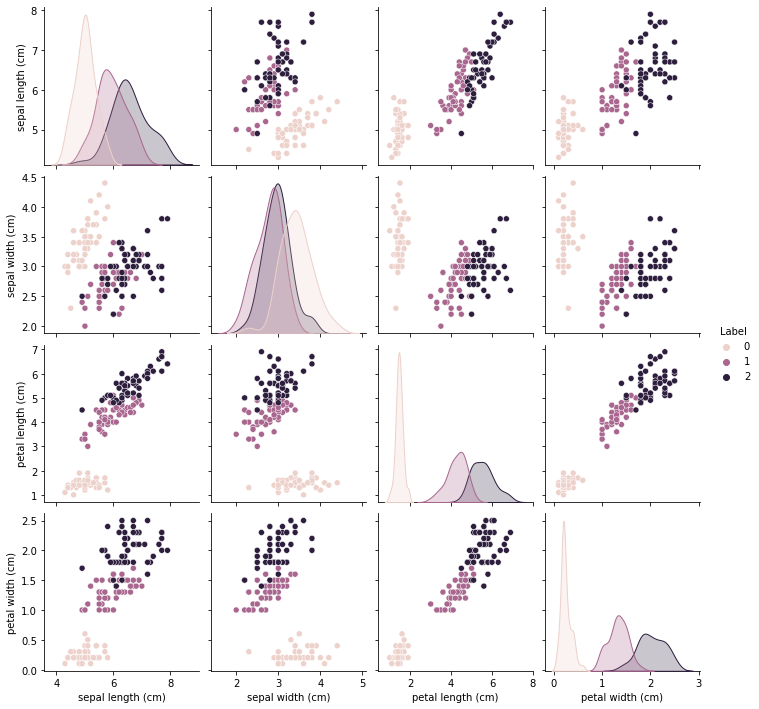

In [ ]:
sns.pairplot(df,hue='Label')

### Normalize and Encode the Data

To prepare data to neural network training, we need to normalize inputs in the range [0..1]. This can be done either using plain `numpy` operations, or [Scikit Learn methods](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html).

Also, you need to decide if you want target label to be one-hot encoded or not. PyTorch and TensorFlow allow you feed in class number either as an integer (from 0 to N-1), or as one-hot encoded vector. When creating neural network structure, you need to specify loss function accordingly (eg. *sparse categorical crossentropy* for numeric representation, and *crossentropy loss* for one-hot encoding). One-hot encoding can also be [done using Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), or by using this piece of code:

```python
n_values = np.max(labels) + 1
labels_onehot = np.eye(n_values)[labels]
```

In [ ]:
# Code to normalize and encode the data
# classification task -> cross entropy error loss function

# cross entropy error loss function on Pytorch

# torch.nn.CrossEntropyLoss

# input : unnorm logits
# label: indices (0, 1, 2)


df.values.shape # -> convert all values -> numpy array

inputs = df.values[:, :4]
labels = df.values[:, 4]

inputs[:5], labels[:5]

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2]]),
 array([0., 0., 0., 0., 0.]))

### Split the Data into Train and Test

Since we do not have separate train and test dataset, we need to split it intro train and test dataset [using Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [ ]:
# Split the data using sklearn

from sklearn.model_selection import train_test_split

train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, train_size=0.8)

In [ ]:
import torch
dataset = torch.utils.data.TensorDataset(torch.tensor(train_inputs, dtype=torch.float32),torch.tensor(train_labels,dtype=torch.int32)) # dataset (train_data, train_labels)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=16, shuffle = True) # dataset -> loader, shuffle data after every epoch

val_dataset = torch.utils.data.TensorDataset(torch.tensor(test_inputs, dtype=torch.float32),torch.tensor(test_labels,dtype=torch.int32)) # dataset (train_data, train_labels)
val_dataloader = torch.utils.data.DataLoader(dataset,batch_size=16, shuffle = False) # dataset -> loader, shuffle data after every epoch



### Define and Train Neural Network

Now you are ready to go, import your preferred framework, define the neural network and start training, observing the behavior of train and validation accuracy.

In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 38.8 MB/s eta 0:00:00


In [ ]:
# Define the network
import pytorch_lightning as pl
import torch
import torch.nn as nn

class MyNetPL(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(4, 10)
        self.fc2 = torch.nn.Linear(10, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_nb): # calculation of training loss from batch of data
        x, y = batch # x: (b, 4) y: (b) y: integer
        # self(x) --> self.forward(x)
        loss = torch.nn.CrossEntropyLoss()(self.forward(x), y.long())
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr = 0.005)
        return optimizer

    def validation_step(self, batch, batch_nb): # calculate loss, accuracy in validation step
        x, y = batch # x: (b, 4) y: (b)
        output = self.forward(x)
        val_loss = torch.nn.CrossEntropyLoss()(output, y.long())
        self.log('val_loss', val_loss, on_step=True, on_epoch=True)
        self.log('val_acc', (output.argmax(-1)==y).float().mean().item(), prog_bar=True, on_epoch=True)

    def test_step(self, batch, batch_nb): # calculate loss, accuracy in validation step
        x, y = batch # x: (b, 4) y: (b)
        output = self.forward(x)
        test_loss = torch.nn.CrossEntropyLoss()(output, y.long())
        self.log('test_loss', test_loss, on_step=True, on_epoch=True)
        self.log('test_acc', (output.argmax(-1)==y).float().mean().item(), prog_bar=True, on_epoch=True)


In [ ]:
# Train the network
import wandb
wandb.init(project='pt-lightning-iris', name='neural-net-2layer-linear')



epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
train_loss_epoch,█▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▇█▇▇▇▇▇▆▇▆▆▆▆▇▆▅▄▄▄▄▃▄▄▃▃▃▃▃▃▃▂▂▃▂▃▃▂▁▂▂
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇█████
val_acc,▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▇▅▆▆▆▇██▇███████████
val_loss_epoch,█▆▆▅▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,█▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▂▁▂
epoch,199
train_loss_epoch,0.32864
train_loss_step,0.38039
trainer/global_step,1599


In [ ]:
net = MyNetPL()
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
trainer = pl.Trainer(max_epochs = 200, logger=pl.loggers.WandbLogger(), log_every_n_steps = 1, accelerator='cpu', callbacks=[
                                                                                                      ModelCheckpoint(filename='best_model_{val_acc}.pt', monitor='val_acc', mode="max")])
trainer.fit(model = net, train_dataloaders = dataloader, val_dataloaders = val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 50     | train
1 | fc2  | Linear | 33     | train
----------------------------------------
83        Trainable params
0         Non-trainable params
83        Total params
0.000     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


In [ ]:
# Visualize train/validation accuracy graph

In [ ]:
# Testing
net = MyNetPL.load_from_checkpoint('/content/lightning_logs/lsvelwty/checkpoints/best_model_val_acc=0.9750000238418579.pt.ckpt')


In [ ]:
trainer.test(net, val_dataloader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9750000238418579     │
│      test_loss_epoch      │    0.47341689467430115    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.47341689467430115, 'test_acc': 0.9750000238418579}]

In [ ]:
for x, y in val_dataloader:
    out = net(x)
    pred = out.argmax(-1)
    break

In [ ]:
out, pred, y

(tensor([[ 1.6833,  0.0734, -1.8537],
         [-2.1438,  2.0062,  2.4102],
         [-2.6405,  2.3240,  3.3162],
         [-1.2753,  1.4763,  1.6342],
         [ 2.0155, -0.0583, -2.2080],
         [-0.9665,  1.3438,  1.0782],
         [-0.5215,  1.2060,  0.7807],
         [ 1.6927,  0.1152, -1.7657],
         [-0.8556,  1.4459,  1.1333],
         [-0.6895,  1.1585,  0.8510],
         [-0.9199,  1.4115,  1.0720],
         [-0.7012,  1.1581,  0.7502],
         [-0.7483,  1.1690,  0.7261],
         [-1.7078,  1.7423,  1.9434],
         [-1.6164,  1.7008,  2.0791],
         [-1.1800,  1.5035,  1.6234]], grad_fn=<AddmmBackward0>),
 tensor([0, 2, 2, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2]),
 tensor([0, 2, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2], dtype=torch.int32))

### Experiment

Now you can experiment with different network architectures to see how it affects the result. Try:
1. One-layer network with 3 neurons (equal to the number of classes)
1. Two-layer network with small/medium/large hidden layer
1. Using more layers

Make sure you observe overfitting when you are using rich model with lots of neurons (parameters).

In [ ]:
# Experiment

## Part 2: MNIST Training

Both Keras and PyTorch contain MNIST as built-in dataset, so you can easily get it with a couple of lines of code ([Keras](https://keras.io/api/datasets/mnist/), [PyTorch](https://pytorch.org/vision/stable/datasets.html)). You will also be able to load both train and test datasets without manually splitting them.

In [ ]:
# Load the dataset

Now you need to perform the steps above to make sure dataset is normalized (it would probably already be), defining and training a neural network.

## Takeaway

1. Neural networks can be used for traditional machine learning tasks. However, they are in many cases too powerful, and can cause overfitting.
1. It is important in this assignment that you observe the overfitting behavior, and try to avoid it.
1. With frameworks like Keras, sometimes training a neural network is quite straightforward. But you need to understand what goes on.